In [4]:
import numpy as np 
import pandas as pd 
import os
import keras
import tensorflow as tf
import tensorflow
import keras
import sklearn
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from platform import  python_version
from glob import glob
from keras import backend as K
from tqdm import tqdm
from PIL import Image
from patchify import patchify
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
import shutil
import segmentation_models as sm
import warnings
from dotenv import load_dotenv
warnings.filterwarnings("ignore")

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

%config Completer.use_jedi = False

sm.set_framework('tf.keras')
sm.framework()

'tf.keras'

In [5]:
os.getenv("base_dir")
print(os.listdir(base_dir))
print("Keras version : " + keras.__version__)
print("Tensorflow version : " + tf.__version__)
print("Python version : " + python_version())
print("Sklearn version : " + sklearn.__version__)
print("CV2 version : " + cv2.__version__)
print("Pandas version : " + pd.__version__)


['archive.zip', 'class_dict.csv', 'images256', 'masks256', 'metadata.csv', 'pytmaskimgs', 'test', 'train', 'valid']
Keras version : 2.6.0
Tensorflow version : 2.6.0
Python version : 3.9.13
Sklearn version : 1.1.2
CV2 version : 4.7.0
Pandas version : 1.4.4


In [6]:
filenames = pd.read_csv(os.path.join(base_dir, 'metadata.csv'))
filenames

image_id  split        sat_image_path              mask_path
0       100694  train  train/100694_sat.jpg  train/100694_mask.png
1       102122  train  train/102122_sat.jpg  train/102122_mask.png
2        10233  train   train/10233_sat.jpg   train/10233_mask.png
3       103665  train  train/103665_sat.jpg  train/103665_mask.png
4       103730  train  train/103730_sat.jpg  train/103730_mask.png
...        ...    ...                   ...                    ...
1141    979233   test   test/979233_sat.jpg                    NaN
1142    983689   test   test/983689_sat.jpg                    NaN
1143    988205   test   test/988205_sat.jpg                    NaN
1144    989953   test   test/989953_sat.jpg                    NaN
1145    999380   test   test/999380_sat.jpg                    NaN

[1146 rows x 4 columns]

In [7]:
print(filenames['split'].value_counts())

train    803
test     172
valid    171
Name: split, dtype: int64


In [ ]:
train_df = filenames[filenames['split']=='train']
train_df['sat_image_path'] = train_df['sat_image_path'].apply(lambda img_pth: os.path.join(base_dir, img_pth))
train_df['mask_path'] = train_df['mask_path'].apply(lambda img_pth: os.path.join(base_dir, img_pth))

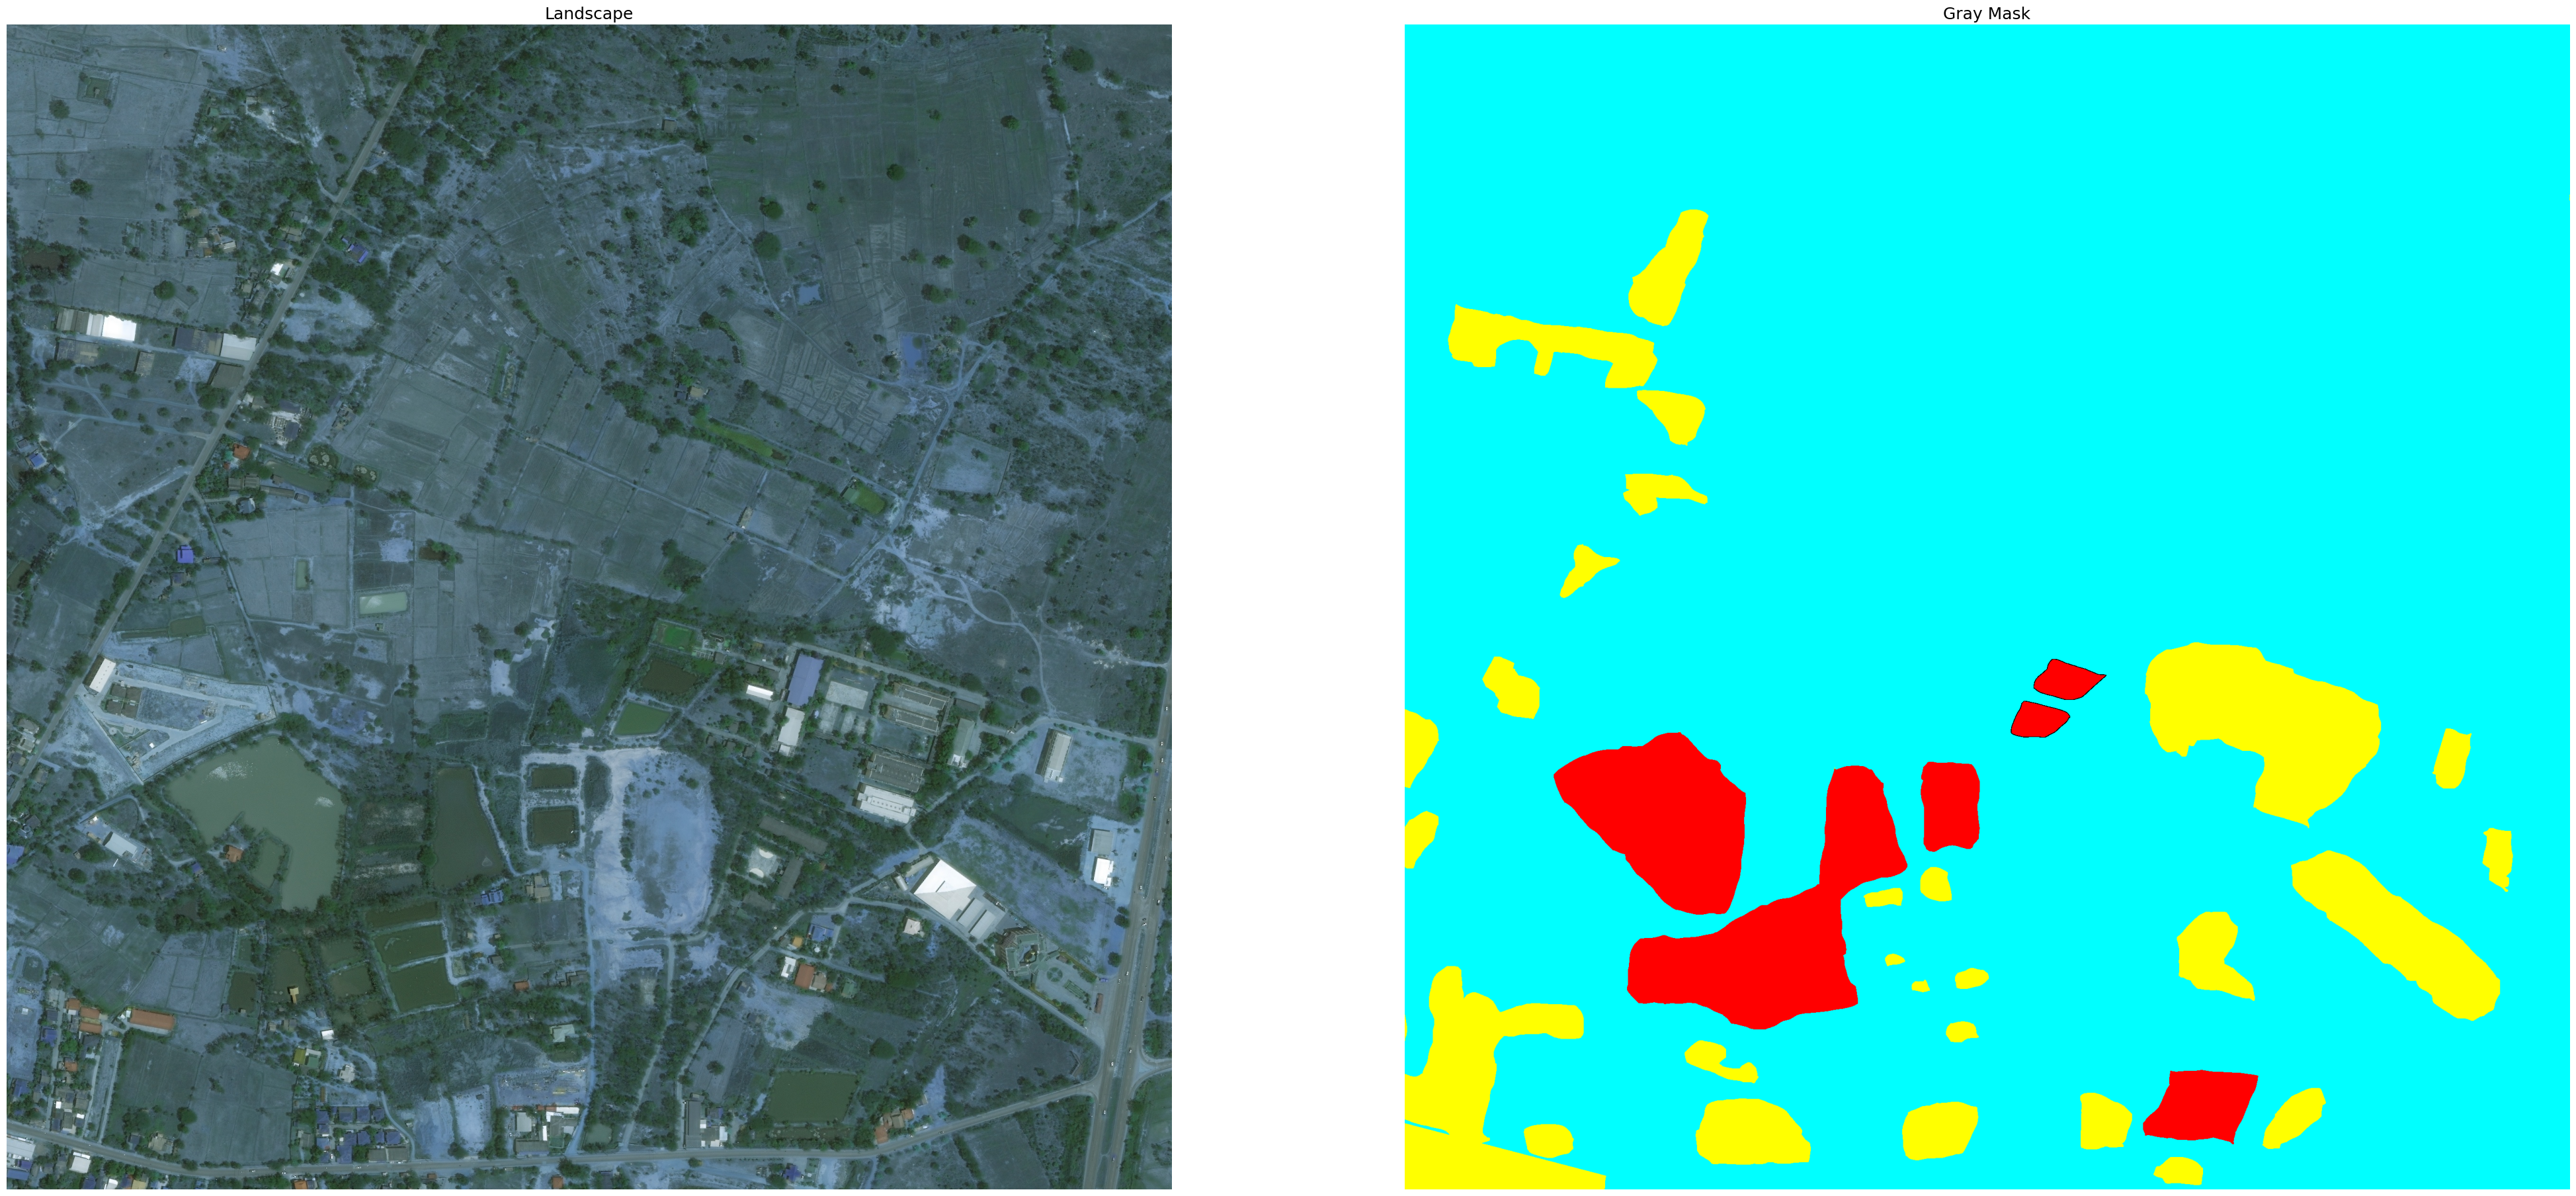

In [9]:
i = np.random.randint(0, len(train_df))
img = cv2.imread(train_df['sat_image_path'].iloc[i])
mask = cv2.imread(train_df['mask_path'].iloc[i])
plt.figure(figsize=(50,50))

plt.subplot(121)
plt.axis('off')
plt.title('Landscape',fontsize=18)
plt.imshow(img)

plt.subplot(122)
plt.axis('off')
plt.title('Gray Mask',fontsize=18 )
plt.imshow(mask)

In [16]:
class_dict = pd.read_csv(os.path.join(base_dir, 'class_dict.csv'))
num_class = len(class_dict)
print(f'Number of classes {num_class}')
class_dict

Number of classes 7


name    r    g    b
0        urban_land    0  255  255
1  agriculture_land  255  255    0
2         rangeland  255    0  255
3       forest_land    0  255    0
4             water    0    0  255
5       barren_land  255  255  255
6           unknown    0    0    0

In [11]:
# #for generating tif images 

# if os.path.exists('masks256') :
#     shutil.rmtree('masks256')
# if os.path.exists('images256') :    
#     shutil.rmtree('images256')
    
# os.mkdir('images256')
# os.mkdir('masks256')
# patch_size =256


# def patches(train_df):
#     num_of_saved_files = 0
#     for img_path, mask_path in tqdm(train_df[['sat_image_path','mask_path']].to_numpy()):
#         image = cv2.imread(img_path, 1)
#         mask = cv2.imread(mask_path)
#         assert image.shape == mask.shape
#         SIZE_X = (image.shape[1]//patch_size)*patch_size 
#         SIZE_Y = (image.shape[0]//patch_size)*patch_size
        
#         image = Image.fromarray(image)
#         image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
#         image = np.array(image)             

#         patches_img = patchify(image, (256, 256, 3), step=256)  #Step=256 for 256 patches means no overlap
#         patches_mask = patchify(mask, (256, 256, 3), step=256) 
        
#         for i in range(patches_img.shape[0]):
#             for j in range(patches_img.shape[1]):
                
#                 single_patch_mask = patches_mask[i,j,:,:]
#                 single_patch_mask = single_patch_mask[0]
                
#                 val, counts = np.unique(single_patch_mask, return_counts=True)
#                 max_counts = np.max(counts)/counts.sum()
#                 if max_counts < 0.95:
#                     single_patch_img = patches_img[i,j,:,:]
#                     single_patch_img = single_patch_img[0]

#                     cv2.imwrite(f'images256/{num_of_saved_files}.tif', single_patch_img)
#                     cv2.imwrite(f'masks256/{num_of_saved_files}.tif', single_patch_mask) 
#                     num_of_saved_files += 1
# patches(train_df)

In [17]:
colors = []
for (r,g,b) in class_dict[['r', 'g', 'b']].to_numpy():
    colors.append([r,g,b])
map_color = {x:v for x,v in zip(range(num_class),colors)}
colors

map_color

{0: [0, 255, 255],
 1: [255, 255, 0],
 2: [255, 0, 255],
 3: [0, 255, 0],
 4: [0, 0, 255],
 5: [255, 255, 255],
 6: [0, 0, 0]}

In [12]:
num_classes =7
def rgb_to_onehot(rgb_arr):
    color_dict= map_color
    num_classes = len(color_dict)
    shape = rgb_arr.shape[:2]+(num_classes,)
    arr = np.zeros( shape, dtype=np.int8 )
    for i, cls_ in enumerate(color_dict):
        arr[:,:,i] = np.all(rgb_arr.reshape( (-1,3) ) == color_dict[i], axis=1).reshape(shape[:2])
    return arr

In [13]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

def preprocess_data_rgb_to_onehot(img, mask, num_class=7):
    masks = np.zeros((mask.shape[0], 256, 256,7))
    for i ,m in enumerate(mask):
        masks[i] =rgb_to_onehot(m)      
        img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)
    return (img,masks)


In [18]:
def onehot_to_rgb(onehot, color_dict= map_color):
    single_layer = np.argmax(onehot, axis=-1)
    output = np.zeros( onehot.shape[:2]+(3,) )
    for k in color_dict.keys():
        output[single_layer==k] = color_dict[k]
    return np.uint8(output)

In [16]:
def one_hot_encode(label):
    label_values = colors
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1).astype('float')

    return semantic_map

In [17]:
def preprocess_data(imgs, masks):
    return (imgs,one_hot_encode(masks))

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

seed=24
batch_size= 8

patched_dir = os.getenv("patched_dir")

def data_generator(num_class=7):
    img_data_gen_args = dict(horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='reflect')
    
    image_datagen = ImageDataGenerator(**img_data_gen_args, rescale=1.0/255.0)
    mask_datagen = ImageDataGenerator(**img_data_gen_args)


    validation_split= 0.2

    df_len = len(glob(os.path.join(patched_dir,'images256/*.tif')))
    subset = np.empty(df_len, dtype=object)
    subset[:int((1-validation_split)*df_len)] = 'train'
    subset[int((1-validation_split)*df_len):] = 'valid'
    np.random.shuffle(subset)
    df_filenames = pd.DataFrame(np.vstack((np.sort(np.array((glob(os.path.join(patched_dir,'images256/*.tif')),glob(os.path.join(patched_dir,'masks256/*.tif'))))), subset)).T, columns = ['img', 'masks','subset'])
    df_train = df_filenames[df_filenames.subset  == 'train']
    df_valid = df_filenames[df_filenames.subset  == 'valid']

    image_train_generator = image_datagen.flow_from_dataframe(
        dataframe = df_train,
        train_dir=None,
        x_col="img",
        batch_size= batch_size,
        seed=24,
        class_mode = None)
    
    mask_train_generator = mask_datagen.flow_from_dataframe(
        dataframe = df_train,
        train_dir=None,
        x_col="masks",
        batch_size= batch_size,
        seed=24,
        class_mode = None)
    

    mask_valid_generator = mask_datagen.flow_from_dataframe(
        dataframe = df_valid,
        train_dir=None,
        x_col="masks",
        batch_size= batch_size,
        seed=24,
        class_mode = None)
   

    image_valid_generator = image_datagen.flow_from_dataframe(
        dataframe = df_valid,
        train_dir=None,
        x_col="img",
        batch_size= batch_size,
        seed=24,
        class_mode = None) 
     
    train_generator= zip(image_train_generator,mask_train_generator)
    valid_generator = zip(image_valid_generator, mask_valid_generator)
    return(train_generator,valid_generator)
   
def transform_generator(gen):
    for (img, mask) in gen:
        img, mask = preprocess_data(img, mask)
        yield (img, mask)
        
def train_valid_gen(num_class=7):
    train_gen,valid_gen = data_generator(num_class=num_class)
    train_gen = transform_generator(train_gen)
    valid_gen = transform_generator(valid_gen)
    return (train_gen,valid_gen)

In [19]:
t, v = train_valid_gen()

Found 48984 validated image filenames.
Found 48984 validated image filenames.
Found 12247 validated image filenames.
Found 12247 validated image filenames.


In [20]:
%%time
x, y=next(t)

CPU times: total: 125 ms
Wall time: 132 ms


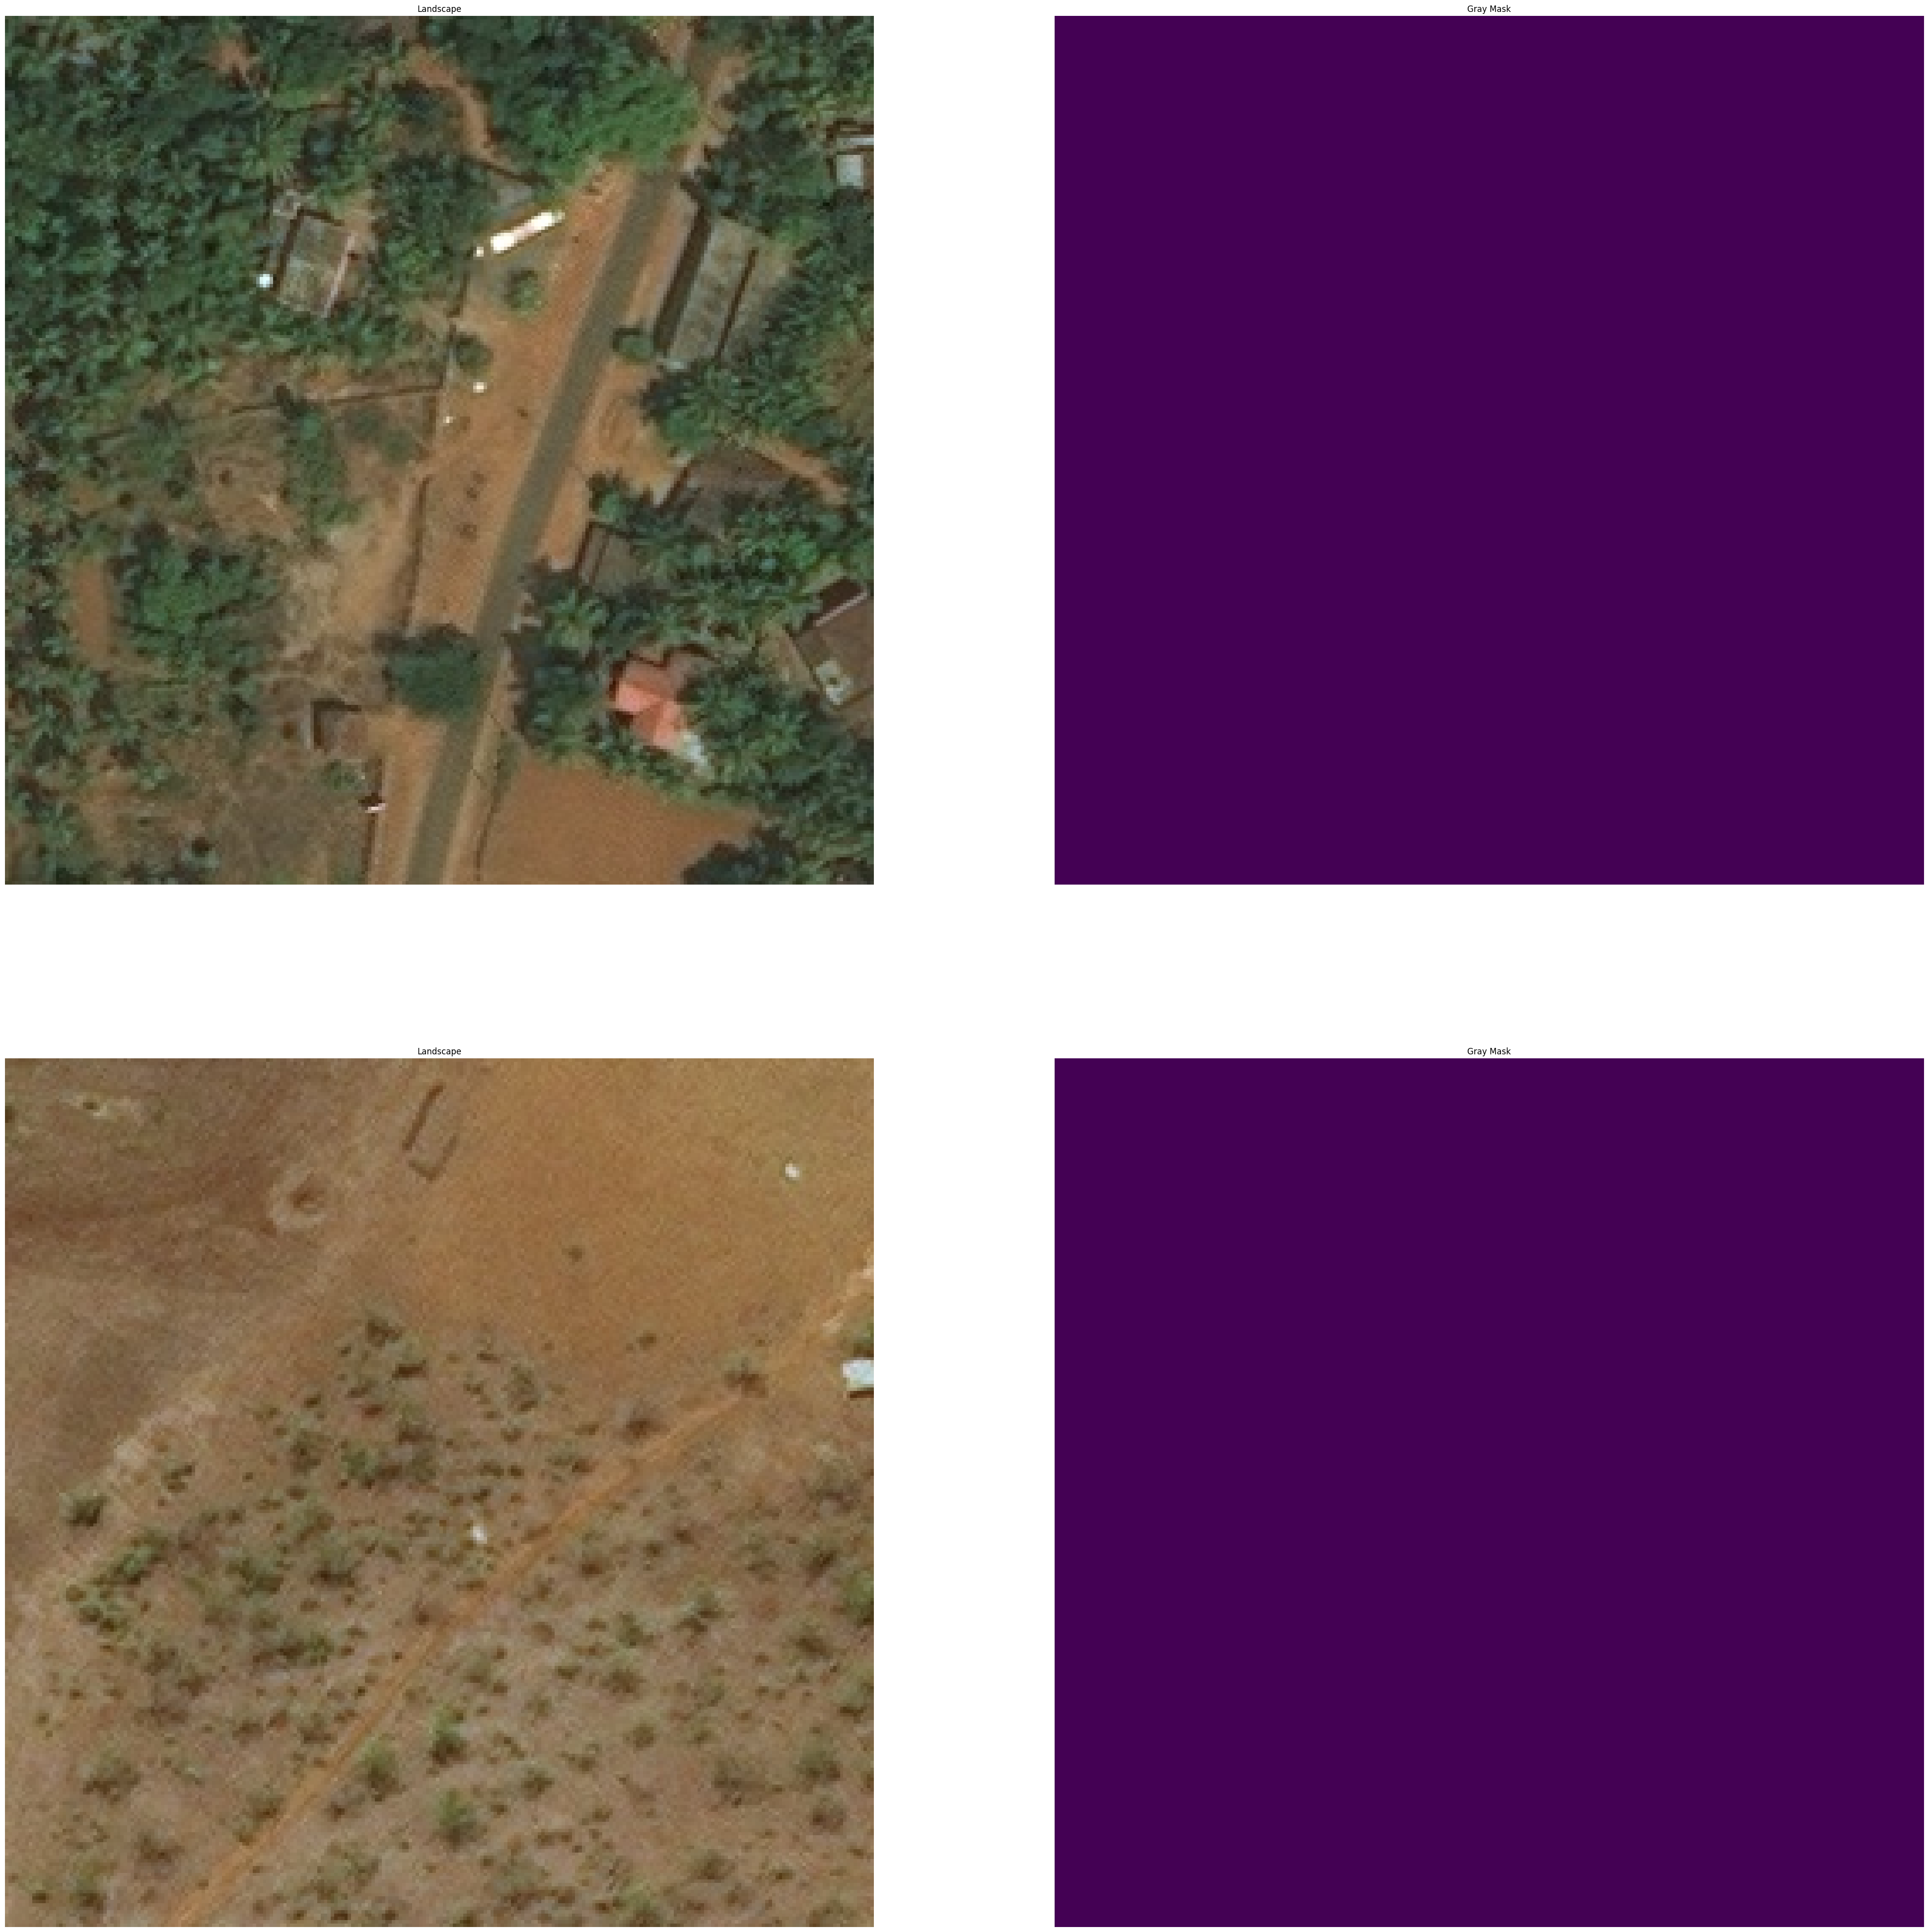

In [22]:
def check_gens(train_gen, valid_gen):
    x, y = next(train_gen)
    i =6
    plt.figure(figsize = (50,50))
    plt.subplot(221)
    plt.axis('off')
    plt.title('Landscape')
    plt.imshow(x[i])

    plt.subplot(222)
    plt.axis('off')
    plt.title('Gray Mask')
    mask =  cv2.imread(os.getenv("img1"))
    plt.imshow(np.argmax((y)[i],axis=2)*64)


    x, y = next(valid_gen)
    plt.subplot(223)
    plt.axis('off')
    plt.title('Landscape')
    plt.imshow(x[i])

    plt.subplot(224)
    plt.axis('off')
    plt.title('Gray Mask')
    mask =  cv2.imread(os.getenv("img2"))
    plt.imshow(np.argmax((y)[i],axis=2)*64)
check_gens(t,v)

In [23]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard

def callback(name):
    checkpoint = ModelCheckpoint("{}.h5".format(name), monitor='val_iou_score', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)
    reduce = ReduceLROnPlateau(monitor='val_iou_score',
                                   patience=2, 
                                   verbose=1, mode='min', epsilon=0.0001, cooldown=2, min_lr=1e-6)

    early = EarlyStopping(monitor="val_iou_score", 
                      mode="min", 
                      patience=2)
    
    tensorboard = TensorBoard(log_dir="logs/{}".format(name))
    
    callbacks = [checkpoint, early, reduce,tensorboard]

In [24]:
def unet(input_size=(256,256,3)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(num_class, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [25]:
model = unet()
from tensorflow.keras.metrics import MeanIoU
model.compile(optimizer = Adam(lr = 0.0001), loss=sm.losses.categorical_focal_jaccard_loss, metrics=[sm.metrics.iou_score])

In [26]:
# CB = callback('conv')
# history = model.fit_generator(t,
#                 steps_per_epoch=2692// batch_size,
#                 epochs=50, validation_data = v, validation_steps=300//batch_size,
#                  callbacks =CB)

In [27]:
#U-net using segmentation models

def u_net_models(backbones):
    
    metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5), 'accuracy']
    histories = {}
    
    for backbone in backbones:
        callbacks = callback(backbone)
        
        model = sm.Unet(backbone, encoder_weights='imagenet', 
                input_shape=(256,256,3),
                classes=7, activation='softmax')
        model.compile(optimizer = Adam(lr = 0.0001), loss=sm.losses.categorical_focal_jaccard_loss, metrics=metrics)
        
        train_gen,valid_gen = train_valid_gen(7)
        print('Model : {}'.format(backbone))
        history = model.fit_generator(train_gen,
                steps_per_epoch=2692// batch_size,
                epochs=50, validation_data = valid_gen, validation_steps=300//batch_size, callbacks =callbacks)
        model.save('{}.h5'.format(backbone))
        histories[backbone] = history
    return histories

In [30]:
backbones = ['resnet34', 'inceptionv3', 'vgg16']
histories = u_net_models(backbones)

Found 48984 validated image filenames.
Found 48984 validated image filenames.
Found 12247 validated image filenames.
Found 12247 validated image filenames.
Model : resnet34
Epoch 1/50
336/336 [==============================] - 163s 456ms/step - loss: 0.8548 - iou_score: 0.4054 - f1-score: 0.4527 - accuracy: 0.6294 - val_loss: 1.2419 - val_iou_score: 0.2552 - val_f1-score: 0.2587 - val_accuracy: 0.0301
Epoch 2/50
336/336 [==============================] - 156s 466ms/step - loss: 0.7765 - iou_score: 0.4817 - f1-score: 0.5347 - accuracy: 0.7115 - val_loss: 1.2275 - val_iou_score: 0.2643 - val_f1-score: 0.2689 - val_accuracy: 0.0410
Epoch 3/50
336/336 [==============================] - 153s 455ms/step - loss: 0.7646 - iou_score: 0.4945 - f1-score: 0.5485 - accuracy: 0.7234 - val_loss: 1.0016 - val_iou_score: 0.3053 - val_f1-score: 0.3441 - val_accuracy: 0.2912
Epoch 4/50
336/336 [==============================] - 159s 473ms/step - loss: 0.7451 - iou_score: 0.5078 - f1-score: 0.5628 - accur

ResourceExhaustedError:  OOM when allocating tensor with shape[8,32,256,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/model_4/decoder_stage4a_conv/Conv2D/Conv2DBackpropFilter-0-TransposeNHWCToNCHW-LayoutOptimizer}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_196584]

Function call stack:
train_function


In [27]:
history = u_net_models(['vgg16'])

Found 48984 validated image filenames.
Found 48984 validated image filenames.
Found 12247 validated image filenames.
Found 12247 validated image filenames.
Model : vgg16
Epoch 1/50
336/336 [==============================] - 244s 657ms/step - loss: 0.8939 - iou_score: 0.3510 - f1-score: 0.3977 - accuracy: 0.5803 - val_loss: 0.8373 - val_iou_score: 0.4737 - val_f1-score: 0.5198 - val_accuracy: 0.7081
Epoch 2/50
336/336 [==============================] - 227s 676ms/step - loss: 0.8199 - iou_score: 0.4794 - f1-score: 0.5257 - accuracy: 0.7047 - val_loss: 0.8102 - val_iou_score: 0.4760 - val_f1-score: 0.5161 - val_accuracy: 0.7905
Epoch 3/50
336/336 [==============================] - 255s 760ms/step - loss: 0.8027 - iou_score: 0.4605 - f1-score: 0.5104 - accuracy: 0.7037 - val_loss: 0.8011 - val_iou_score: 0.4401 - val_f1-score: 0.4939 - val_accuracy: 0.6943
Epoch 4/50
336/336 [==============================] - 236s 703ms/step - loss: 0.7850 - iou_score: 0.4672 - f1-score: 0.5201 - accuracy

In [29]:
#number of epochs= 100/150

def u_net_models(backbones):
    
    metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5), 'accuracy']
    histories = {}
    
    for backbone in backbones:
        callbacks = callback(backbone)
        
        model = sm.Unet(backbone, encoder_weights='imagenet', 
                input_shape=(256,256,3),
                classes=7, activation='softmax')
        model.compile(optimizer = Adam(lr = 0.0001), loss=sm.losses.categorical_focal_jaccard_loss, metrics=metrics)
        
        train_gen,valid_gen = train_valid_gen(7)
        print('Model : {}'.format(backbone))
        history = model.fit_generator(train_gen,
                steps_per_epoch=2692// batch_size,
                epochs=150, validation_data = valid_gen, validation_steps=300//batch_size, callbacks =callbacks)
        model.save('{}.h5'.format(backbone))
        histories[backbone] = history
    return histories

inceptionv3_history = u_net_models(['inceptionv3'])

Found 48984 validated image filenames.
Found 48984 validated image filenames.
Found 12247 validated image filenames.
Found 12247 validated image filenames.
Model : inceptionv3
Epoch 1/150
336/336 [==============================] - 184s 472ms/step - loss: 0.8650 - iou_score: 0.4113 - f1-score: 0.4536 - accuracy: 0.6281 - val_loss: 0.8115 - val_iou_score: 0.4781 - val_f1-score: 0.5186 - val_accuracy: 0.7572
Epoch 2/150
336/336 [==============================] - 166s 495ms/step - loss: 0.7797 - iou_score: 0.4771 - f1-score: 0.5236 - accuracy: 0.7313 - val_loss: 0.7500 - val_iou_score: 0.4916 - val_f1-score: 0.5356 - val_accuracy: 0.7807
Epoch 3/150
336/336 [==============================] - 183s 545ms/step - loss: 0.7609 - iou_score: 0.4295 - f1-score: 0.4850 - accuracy: 0.7140 - val_loss: 0.7203 - val_iou_score: 0.5159 - val_f1-score: 0.5634 - val_accuracy: 0.8002
Epoch 4/150
336/336 [==============================] - 181s 538ms/step - loss: 0.7420 - iou_score: 0.4448 - f1-score: 0.5036 

In [28]:
backbones = ['vgg19', 'resnet50']
histories = u_net_models(backbones)

Found 48984 validated image filenames.
Found 48984 validated image filenames.
Found 12247 validated image filenames.
Found 12247 validated image filenames.
Model : vgg19
Epoch 1/50
336/336 [==============================] - 283s 791ms/step - loss: 0.9067 - iou_score: 0.3363 - f1-score: 0.3783 - accuracy: 0.5813 - val_loss: 0.8285 - val_iou_score: 0.4817 - val_f1-score: 0.5270 - val_accuracy: 0.7421
Epoch 2/50
336/336 [==============================] - 265s 788ms/step - loss: 0.8287 - iou_score: 0.4689 - f1-score: 0.5194 - accuracy: 0.6793 - val_loss: 0.8349 - val_iou_score: 0.4664 - val_f1-score: 0.5122 - val_accuracy: 0.7432
Epoch 3/50
336/336 [==============================] - 269s 801ms/step - loss: 0.8047 - iou_score: 0.4713 - f1-score: 0.5256 - accuracy: 0.6906 - val_loss: 0.8402 - val_iou_score: 0.4099 - val_f1-score: 0.4723 - val_accuracy: 0.5904
Epoch 4/50
336/336 [==============================] - 259s 771ms/step - loss: 0.7902 - iou_score: 0.4461 - f1-score: 0.5029 - accuracy

ResourceExhaustedError:  OOM when allocating tensor with shape[8,32,256,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/model_3/decoder_stage4a_conv/Conv2D/Conv2DBackpropFilter-0-TransposeNHWCToNCHW-LayoutOptimizer}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_94342]

Function call stack:
train_function


| Model          | Val Accuracy  | Val Loss   | Val IOU Score   | Val F1-Score   |
| -------------  | ------------- | ---------- | --------------- | -------------- |
| inceptionv3    | 0.8481       | 0.50     | 0.6201          | 0.6703         |
| vgg19          | 0.8560       | 0.6398     | 0.5971          | 0.6500         |
| vgg16          | 0.8271       | 0.6546     | 0.6039          | 0.6615         |
| resnet34       | 0.8250       | 0.6612     | 0.5832          | 0.6437         |


In [19]:
models_path = os.getenv("Model_paths")

In [20]:
def predict_image(model, img):
    w,h = img.shape[:2]
    w = w // 256 +1
    h = h // 256 +1
    padding_shape = (w*256,h*256 ,3)
    padded_img= np.zeros(padding_shape)
    mask_shape = (w*256,h*256,7)

    padded_img[0:img.shape[0], 0:img.shape[1], :] = img
    padded_img = padded_img/255
    mask_padded = np.zeros(mask_shape)

    for i in range(0,mask_shape[0], 256):
        for j in range(0, mask_shape[1], 256):
            patch = padded_img[i:i+256,j:j+256,:]
            predicted  = model.predict(np.expand_dims(patch,axis=0))
            mask_padded[i:i+256,j:j+256,:] =predicted 
    return mask_padded[0:img.shape[0], 0:img.shape[1], :]

def predict(img, paths):
    predicted_masks = []
    for path in models_path:
        model = keras.models.load_model(path,
                                        custom_objects={'focal_loss_plus_jaccard_loss': sm.losses.categorical_focal_jaccard_loss,
                                                        'iou_score':sm.metrics.IOUScore, 
                                                        'threshold': 0.5, 'f1-score':sm.metrics.FScore})

        predicted_masks.append(predict_image(model, img))
    return predicted_masks

def plot(predicted_masks):
    backbones = ['vgg19', 'inceptionv3']
    plt.figure(figsize=(50,50))
    plt.subplots_adjust(bottom=0.3, top=0.7, hspace=0)

    plt.subplot(151)
    plt.title('Original Image' ,fontsize=18)
    plt.axis('off')
    plt.imshow(img)

    plt.subplot(152)
    plt.title('Mask {}'.format(backbones[0]) ,fontsize=18)
    plt.axis('off')
    plt.imshow(onehot_to_rgb(predicted_masks[0]))

    plt.subplot(153)
    plt.title('Mask {}'.format(backbones[1]) ,fontsize=18)
    plt.axis('off')
    plt.imshow(onehot_to_rgb(predicted_masks[1]))


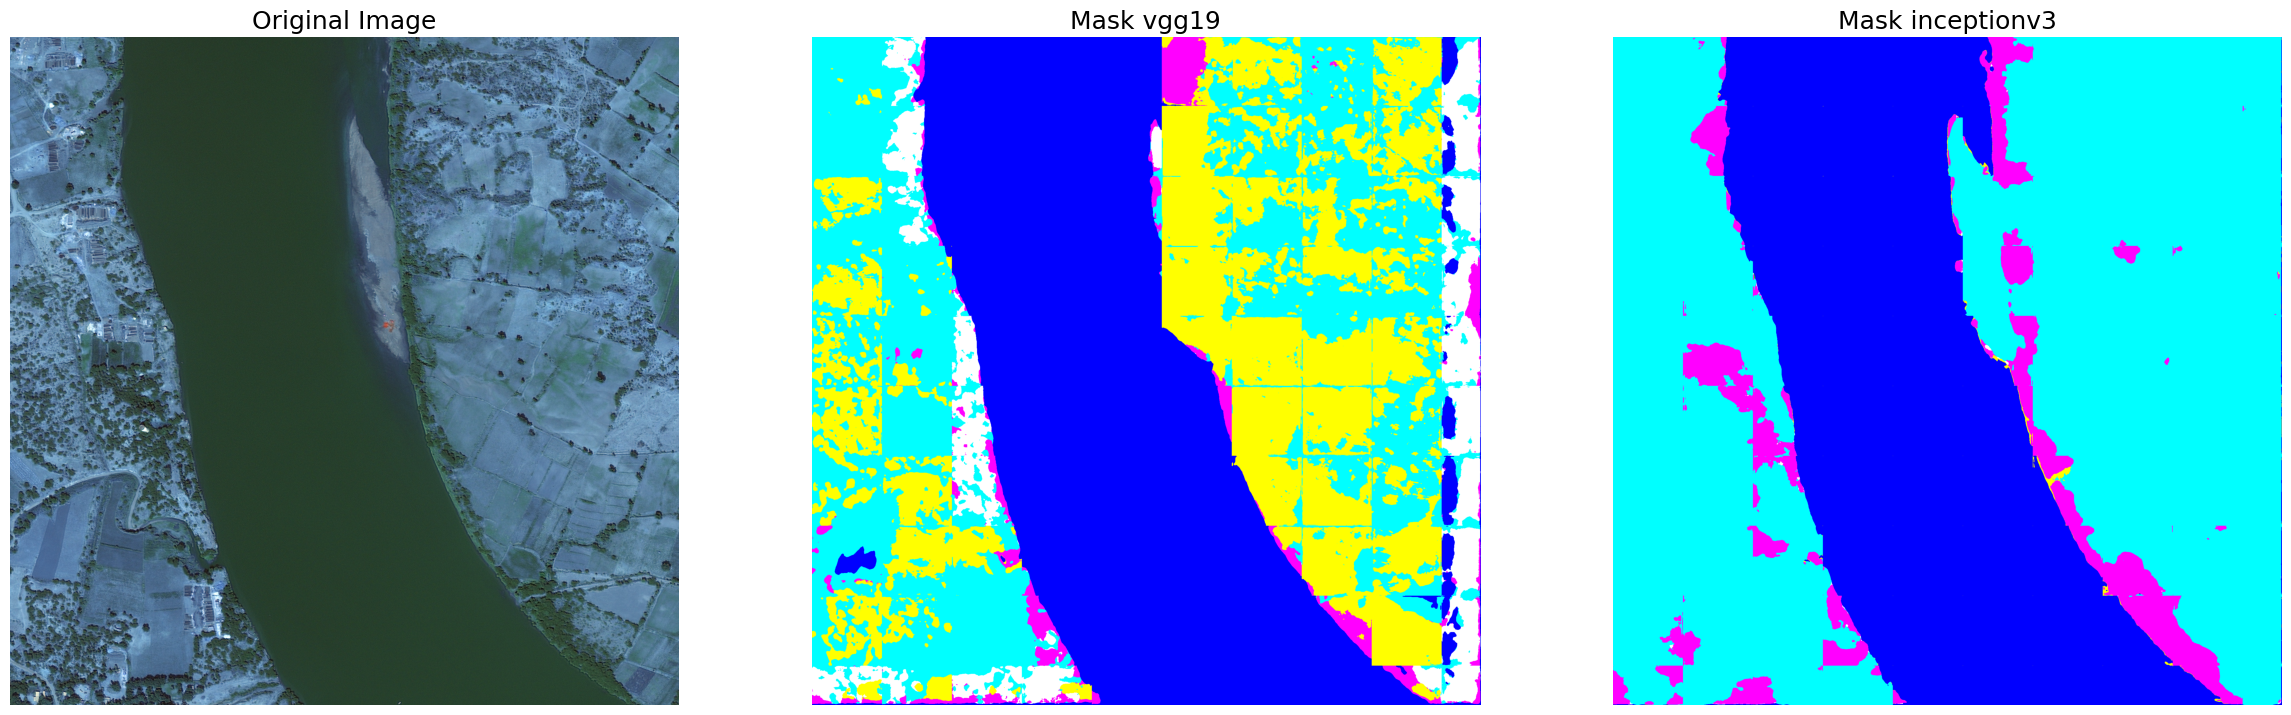

In [28]:
img = cv2.imread(os.getenv("img3"))
predicted_masks = predict(img, models_path)
plot(predicted_masks)

In [ ]:
def onehot_to_rgb(onehot):
    color_dict = {0: [0, 255, 255], 1: [255, 255, 0], 2: [255, 0, 255],  3: [0, 255, 0], 4: [0, 0, 255], 5: [255, 255, 255],  6: [0, 0, 0]}
    single_layer = np.argmax(onehot, axis=-1)
    output = np.zeros( onehot.shape[:2]+(3,) )
    for k in color_dict.keys():
        output[single_layer==k] = color_dict[k]
    return np.uint8(output)

def predict_image(model, img):
    w,h = img.shape[:2]
    w = w // 256 +1
    h = h // 256 +1
    padding_shape = (w*256,h*256 ,3)
    padded_img= np.zeros(padding_shape)
    mask_shape = (w*256,h*256,7)

    padded_img[0:img.shape[0], 0:img.shape[1], :] = img
    padded_img = padded_img/255
    mask_padded = np.zeros(mask_shape)

    for i in range(0,mask_shape[0], 256):
        for j in range(0, mask_shape[1], 256):
            patch = padded_img[i:i+256,j:j+256,:]
            predicted  = model.predict(np.expand_dims(patch,axis=0))
            mask_padded[i:i+256,j:j+256,:] =predicted 
    return mask_padded[0:img.shape[0], 0:img.shape[1], :]

def function1(img):
    model = keras.models.load_model(os.getenv("m1"),
                                    custom_objects={'focal_loss_plus_jaccard_loss': sm.losses.categorical_focal_jaccard_loss,
                                                    'iou_score': sm.metrics.IOUScore, 
                                                    'threshold': 0.5, 'f1-score':sm.metrics.FScore})

        res = predict_image(model, img)
    return onehot_to_rgb(res)

def function2(img):
    model = keras.models.load_model(os.getenv("m2"),
                                    custom_objects={'focal_loss_plus_jaccard_loss': sm.losses.categorical_focal_jaccard_loss,
                                                    'iou_score': sm.metrics.IOUScore, 
                                                    'threshold': 0.5, 'f1-score':sm.metrics.FScore})

    res = predict_image(model, img)
    return onehot_to_rgb(res)

In [ ]:
def plot(img):
    backbones = ['inceptionv3', 'vgg19']
    plt.figure(figsize=(50,50))
    plt.subplots_adjust(bottom=0.3, top=0.7, hspace=0)

    plt.subplot(151)
    plt.title('Original Image' ,fontsize=18)
    plt.axis('off')
    plt.imshow(img)

    plt.subplot(152)
    plt.title('Mask {}'.format(backbones[0]) ,fontsize=18)
    plt.axis('off')
    plt.imshow(function1(img))

    plt.subplot(153)
    plt.title('Mask {}'.format(backbones[1]) ,fontsize=18)
    plt.axis('off')
    plt.imshow(function1(img))

In [ ]:
img = cv2.imread(os.getenv("img4"))
plot(img)

In [ ]:
img = cv2.imread(os.getenv("img5"))
plot(img)